# Don't fit a histogram for crying outloud! Use a proper method.

In [1]:
import numpy as np
import pymc3 as pm
import emcee
import scipy.optimize as op
import scipy.stats as sts
import lmfit
import corner
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
#rc('font', family='serif')
%matplotlib inline

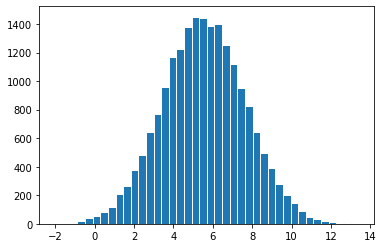

In [2]:
true_mu = 5.5
true_sd = 2.1
n_samp = 20000

data = np.random.normal(true_mu,true_sd,n_samp)
plt.hist(data,bins=40,edgecolor='w');

Population/mixture likelihood:
$$ \mathcal{L} = f(x | \theta) = \sum_0^{i=N} f(x_i|\theta) $$

Where $f$ is the model distribution, $\theta$ is model parametrization, and $N$ is total number of data points $x$.

In [3]:
def gaussian(x, mu, sd):
    return 1./(np.sqrt(2.*np.pi)*sd)*np.exp(-np.power((x - mu)/sd, 2.)/2)

def loglike(theta, x):
    mu, sd = theta
    return np.log(gaussian(x,mu,sd)).sum()

## Method 1: Scipy stat's fitter with built-in models

5.517056189133575 2.1060778358449976


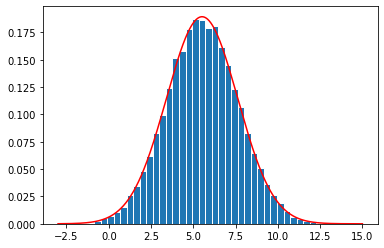

In [4]:
scipy_MLE_mu, scipy_MLE_sigma = sts.norm.fit(data)
print(scipy_MLE_mu, scipy_MLE_sigma)
plt.figure()
plt.hist(data,bins=40,edgecolor='w',density=True);
fit_x = np.linspace(-3,15,1000)
plt.plot(fit_x,gaussian(fit_x,scipy_MLE_mu, scipy_MLE_sigma),'-r')

## Method 2: Scipy optimize, with defining distribution and likelihood

[5.51705627 2.10607788]


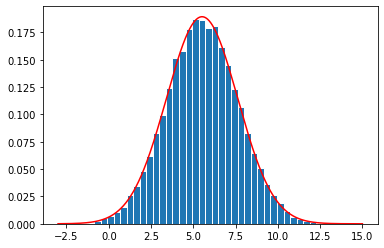

In [5]:
nll = lambda *args: -loglike(*args)
scipy_opt_res = op.minimize(nll, [5.0,2.0], args=(data))
print(scipy_opt_res["x"])
plt.figure()
plt.hist(data,bins=40,edgecolor='w',density=True);
plt.plot(fit_x,gaussian(fit_x,scipy_opt_res["x"][0],scipy_opt_res["x"][1]),'-r')

## LMFIT minimization

In [6]:
p = lmfit.Parameters()
p.add_many(('mu',5.0,True,0.0,10.0),
           ('sigma',2.0,True,0.01,10.0))

def residual(p):
    v = p.valuesdict()
    return -np.log(gaussian(data,v['mu'],v['sigma'])).sum()

mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit',)
mi.params

name,value,initial value,min,max,vary
mu,5.51699028,5.0,0.00000000,10.0000000,True
sigma,2.10594578,2.0,0.01000000,10.0000000,True


## MCMC with custom likelihood

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 6 jobs)
NUTS: [sigma, mu]
Sampling 12 chains: 100%|██████████| 144000/144000 [01:41<00:00, 1416.73draws/s]
/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,5.512543,0.014764,0.000041,5.484198,5.542016,126802.214100,1.000012
sigma__0,2.091496,0.010503,0.000029,2.071356,2.112367,121031.442771,0.999988


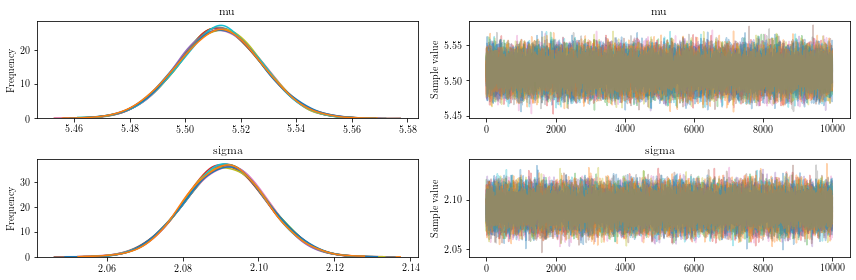

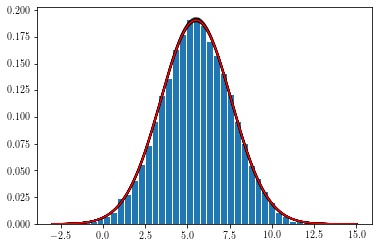

In [24]:
with pm.Model() as custom_mixture_model:
    mu = pm.Uniform('mu',-40,40,shape=(1,))
    sd = pm.Uniform('sigma',0,40,shape=(1,))
    like = pm.Potential('likelihood',np.log(gaussian(data,mu,sd)).sum())
    trace = pm.sample(10000,tune=2000,chains=12,cores=6)

pm.traceplot(trace)

plt.figure()
plt.hist(data,bins=40,edgecolor='w',density=True);
fit_x = np.linspace(-3,15,1000)
for i in np.random.randint(0,len(trace),size=100):
    plt.plot(fit_x,gaussian(fit_x,trace.get_values('mu')[i],trace.get_values('sigma')[i]),'-k',alpha=0.1)
    
plt.plot(fit_x,gaussian(fit_x,np.median(trace.get_values('mu')),np.median(trace.get_values('sigma'))),'-r')

pm.summary(trace)

## MCMC with defined models

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 6 jobs)
NUTS: [sigma, mu]
Sampling 12 chains: 100%|██████████| 144000/144000 [00:48<00:00, 2940.58draws/s]
/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,5.512581,0.014821,0.000047,5.484206,5.542109,115354.534471,1.000034
sigma__0,2.091434,0.010478,0.000027,2.070731,2.111932,119016.775921,1.000008


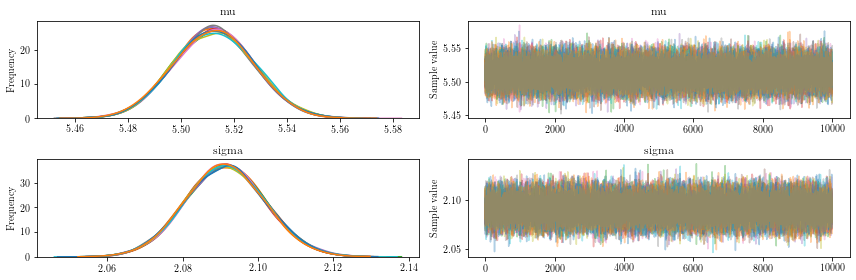

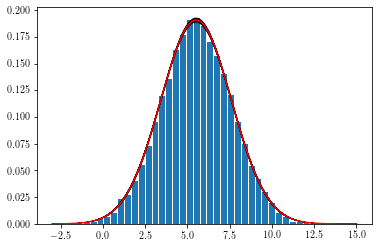

In [21]:
with pm.Model() as mixture_model:
    mu = pm.Uniform('mu',-40,40,shape=(1,))
    sd = pm.Uniform('sigma',0,40,shape=(1,))
    components = pm.Normal.dist(mu=mu,sd=sd, shape=(1,))
    like = pm.Mixture('like', w=[1], comp_dists=components, observed=data)
    trace = pm.sample(10000,tune=2000,chains=12,cores=6)

pm.traceplot(trace)

plt.figure()
plt.hist(data,bins=40,edgecolor='w',density=True);
fit_x = np.linspace(-3,15,1000)
for i in np.random.randint(0,len(trace),size=500):
    plt.plot(fit_x,gaussian(fit_x,trace.get_values('mu')[i],trace.get_values('sigma')[i]),'-k',alpha=0.5,lw=0.1)
    
plt.plot(fit_x,gaussian(fit_x,np.median(trace.get_values('mu')),np.median(trace.get_values('sigma'))),'-r')

pm.summary(trace)